# Working with MEG dataset
MEG dataset from THINGS initiative: https://openneuro.org/datasets/ds004212/versions/2.0.1
### Training data partition
The data is .fif file which needs to be converted into a rather easy to use .npy array.
We will use mne library for this: https://mne.tools/dev/index.html 


We collected extensively sampled object representations using magnetoencephalography (MEG). To this end, we drew on the THINGS database (Hebart et al., 2019), a richly-annotated database of 1,854 object concepts representative of the American English language which contains 26,107 manually-curated naturalistic object images.

ERP = event-related potential; signal with respect to some event
VEP = ERP for visual stimuli



27084 events, 281 time points, 271 channels

## Here we perform NMF experiements. And data matrix as concepts x channes*time

Create clusters of decomposed time components of meg data over multiple seeds.

In [1]:
import numpy as np # type: ignore
import mne, os # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import matplotlib.image as mpimg # type: ignore
import nimfa # type: ignore
import scipy.stats as st # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.decomposition import NMF # type: ignore
from scipy.spatial.distance import cdist # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore

### Functions

In [2]:
def compute_log_likelihood(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute log-likelihood."""
    V_hat = np.dot(W, H)
    err_std_dev = np.sqrt(np.var(V - V_hat))
    log_likelihood = st.norm.logpdf(V, loc=V_hat, scale=err_std_dev).sum()
    return log_likelihood

def compute_aic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute AIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    aic = 2 * n_free_params - 2 * log_likelihood
    return aic, n_free_params

def compute_bic(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    """Compute BIC."""
    log_likelihood = compute_log_likelihood(V, W, H)
    I, J = V.shape
    n_samples = I * J
    n_free_params = np.count_nonzero(W) + np.count_nonzero(H) + 1
    bic = np.log(n_samples) * n_free_params - 2 * log_likelihood
    return bic

def fit_bnmf(V: np.ndarray, k: int):
    bnmf = nimfa.Bd(V, seed='random_c', rank=k, max_iter=500, min_residuals=1e-4, alpha=np.zeros((V.shape[0], k)),
                        beta=np.zeros((k, V.shape[1])), theta=.0, k=.0, sigma=1., skip=100, stride=1,
                        n_w=np.zeros((k, 1)), n_h=np.zeros((k, 1)), n_run=1, n_sigma=False)
    bnmf_fit = bnmf()
    W = bnmf_fit.basis()
    H = bnmf_fit.coef()
    return np.array(W), np.array(H)

def compute_evar_all(V: np.ndarray, W: np.ndarray, H: np.ndarray):
    V_hat = np.dot(W, H)
    rss = np.sum(np.asarray(V_hat - V)**2)
    evar_all = 1. - rss / (V*V).sum()
    return evar_all

def compute_evar_indiv(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int):
    V_hat_d = np.outer(W[:, d], H[d, :])
    rss = np.sum(np.asarray(V_hat_d - V)**2)
    evar_indiv = 1. - rss / (V*V).sum()
    return evar_indiv

def compute_evar_unique(V: np.ndarray, W: np.ndarray, H: np.ndarray, d: int, evar_all: float):
    V_hat_wo_d = np.dot(W[:, np.arange(W.shape[1]) != d], H[np.arange(H.shape[0]) != d, :])
    rss = np.sum(np.asarray(V_hat_wo_d - V)**2)
    evar_rest = 1. - rss / (V*V).sum()
    evar_unique = evar_all - evar_rest
    return evar_unique

def load_epochs(preproc_dir,all_epochs = []):
    for p in range(1,n_participants+1):
        epochs = mne.read_epochs(f'{preproc_dir}/preprocessed_P{str(p)}-epo.fif', preload=False)
        all_epochs.append(epochs)
    return all_epochs

def plot_erfs(epochs,n_sessions,name):
    ctf_layout = mne.find_layout(epochs.info)
    picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
    picks = np.where([i[2]==name for i in ctf_layout.names])[0]

    # get evoked data
    for s in range(n_sessions):    
        evoked = epochs[(epochs.metadata['trial_type']=='test') & (epochs.metadata['session_nr']==s+1)].average()
        evoked.pick_channels(ch_names=picks_epochs)
        plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=0.5,alpha=0.4)
    evoked = epochs[(epochs.metadata['trial_type']=='test')].average()
    evoked.pick_channels(ch_names=picks_epochs)

    # plot ERFs for selected sensor group
    plt.plot(epochs.times*1000,np.mean(evoked.data.T,axis=1),lw=1)
    plt.xlim([epochs.times[0]*1000,epochs.times[len(epochs.times)-1]*1000])
    plt.ylim([-0.6,0.6])
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')  
    plt.title(f'ERFs for {name}')
    plt.show()  

def consensus_nmf(X, n_components=5, n_replicates=10, p=0.3, tau=0.1, random_state=0):
    """
    Perform consensus NMF on non-negative data matrix X.
    
    Parameters:
    -----------
    X : array-like of shape (N, M)
        Non-negative data. Example: N=26000 stimuli, M=271*300 (flattened sensors x time).
    n_components : int
        Number of components K in the factorization and final consensus.
    n_replicates : int
        How many times to run NMF with different random seeds.
    p : float
        Fraction that determines how many nearest neighbors to consider (L = p * R).
    tau : float
        Distance threshold for outlier filtering.
    random_state : int
        Random seed base.
    
    Returns:
    --------
    G_c : array-like, shape (K, M)
        Consensus components (space-time patterns).
    U_c : array-like, shape (N, K)
        Final usage matrix for each of the N stimuli.
    """
    
    N, M = X.shape
    K = n_components
    
    # 1) Multiple NMF replicates
    nmf_models = []
    for r in range(n_replicates):
        nmf = NMF(n_components=K, init='random', max_iter=400,
                  random_state=(random_state + r))
        U_r = nmf.fit_transform(X)
        G_r = nmf.components_  # shape (K, M)
        nmf_models.append((U_r, G_r))
    
    # 2) Normalize each component row (L2) and concatenate
    all_components = []
    for r in range(n_replicates):
        U_r, G_r = nmf_models[r]
        # L2-normalize each row in G_r
        G_r_norm = G_r / (np.linalg.norm(G_r, axis=1, keepdims=True) + 1e-12)
        all_components.append(G_r_norm)
    G_all = np.vstack(all_components)  # shape (R*K, M)
    
    # 3) Outlier Filtering
    #   L = p * R  (the user must ensure L is an integer, or round it)
    L = int(np.ceil(p * n_replicates))
    
    # For each row of G_all, find distance to its L nearest neighbors:
    distances = cdist(G_all, G_all, metric='euclidean')
    # sort distances for each row, exclude the row itself at index 0
    sorted_dists = np.sort(distances, axis=1)[:, 1:]  # skip distance to itself
    mean_L = np.mean(sorted_dists[:, :L], axis=1)     # average distance among L nearest
    # print(mean_L)
    
    # keep those with mean_L < tau
    keep_mask = mean_L < tau
    G_filt = G_all[keep_mask]
    
    # 4) KMeans cluster the filtered components
    kmeans = KMeans(n_clusters=K, random_state=random_state)
    cluster_labels = kmeans.fit_predict(G_filt)
    
    # 5) For each cluster, take the median
    G_c = np.zeros((K, M))
    for k in range(K):
        cluster_rows = G_filt[cluster_labels == k]
        if len(cluster_rows) > 0:
            G_c[k] = np.median(cluster_rows, axis=0)
        else:
            # If a cluster is empty, handle gracefully (e.g. use kmeans cluster center)
            G_c[k] = kmeans.cluster_centers_[k]
    
    # Optionally, L1-normalize each consensus row for interpretability
    G_c = G_c / (np.sum(G_c, axis=1, keepdims=True) + 1e-12)
    
    # 6) Final usage fit: fix G_c, solve for U_c >= 0
    #    We can do it by NMF with init='custom', or by non-negative least squares.
    #    For brevity, here's a quick approach reusing NMF with fix_components style:
    nmf_final = NMF(n_components=K, init='random', max_iter=200, random_state=random_state)
    # We'll set G_c as the init for nmf.components_ and disallow updates to it.
    nmf_final.components_ = G_c.copy()  # shape (K, M)
    # scikit-learn doesn't have a built-in "freeze components" option, so we do partial fit:
    # We'll just do transform with non-negative least squares on each row of X.
    
    # U_c shape: (N, K)
    from sklearn.linear_model import LinearRegression
    U_c = np.zeros((N, K))
    for i in range(N):
        # Solve  min_{u>=0} || X[i,:] - u * G_c ||^2
        # G_c is (K, M), X[i,:] is (M,)
        # This is a standard non-negative LS problem. We can do a quick non-negative solve:
        # For simplicity, we'll do a positivity hack with SciPy or a bigger approach. Let’s do a naive loop:
        
        # OPTIONAL: from scipy.optimize import nnls
        # u_i, _ = nnls(G_c.T, X[i,:])
        # U_c[i,:] = u_i
        # (But let’s just do that if SciPy is allowed. If not, we do an unconstrained solve then clip.)
        
        # Unconstrained LS:
        reg = LinearRegression(fit_intercept=False)
        reg.fit(G_c.T, X[i,:])
        u_pred = reg.coef_
        # Clip negative to 0:
        u_pred[u_pred < 0] = 0
        U_c[i,:] = u_pred
    
    # Finally, normalize each row of U_c so usage sums to 1 across components (if desired)
    row_sums = np.sum(U_c, axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0  # avoid division by zero
    U_c = U_c / row_sums
    
    return G_c, U_c

# ----------------------
# # Example usage:
# if __name__ == "__main__":
#     # Suppose we have MEG data loaded as a 26k x (271*300) matrix
#     # (For demonstration, we’ll just make random non-negative data.)
#     np.random.seed(42)
#     N = 26000
#     M = 271 * 300
#     X_demo = np.random.rand(N, M)  # Already non-negative

#     # Run cNMF with K=5
#     G_c, U_c = consensus_nmf(X_demo, 
#                              n_components=5,
#                              n_replicates=10,
#                              p=0.3,
#                              tau=0.1,
#                              random_state=42)

#     print("G_c shape:", G_c.shape)  # Should be (5, M)
#     print("U_c shape:", U_c.shape)  # Should be (N, 5)
    
#     # "Unwrap" a row of G_c to see sensor x time pattern:
#     # e.g., G_c[0].reshape(271, 300)



In [10]:
channel_picks = ['O','T','P'] 
preproc_dir = '../data/preprocessed'
image_dir = '../data/'

time_window = [0 , 0.8] # in seconds
n_participants = 3 # total number of participants
participant_no = 2
images_to_show = 20
nmf_components = 10
random_state = 0
nos_seeds = 5

NOS_CONCEPTS = 1854
NOS_IMAGE_PER_CONCEPT = 12
NOS_TIME_POINTS = 281
OPTICAL_CHANNELS = True # False if all channels are used

Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 CTF compensation matrices available
Reading /home/atharvsagar/Documents/Neural-Representations-using-Things-Database/notebooks/../data/preprocessed/preprocessed_P1-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1300.00 ms
        0 

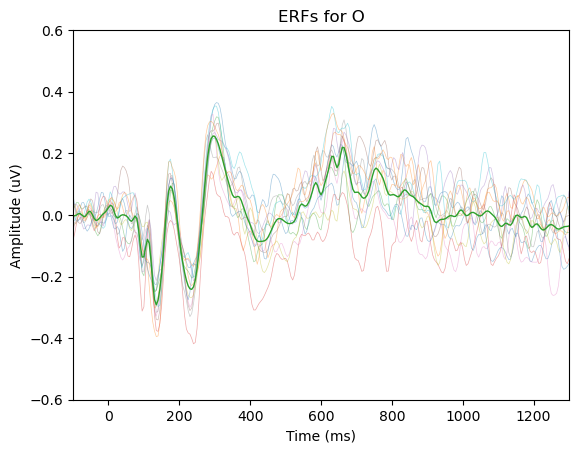

In [4]:
all_epochs = load_epochs(preproc_dir)
n_sessions = 12
plot_erfs(all_epochs[1],n_sessions,'O')
epochs = all_epochs[participant_no]

In [5]:

time_points = epochs.times
name = channel_picks[0]
print(name, channel_picks)
# ctf_layout = mne.find_layout(epochs.info)
picks_epochs = [epochs.ch_names[i] for i in np.where([s[2]==name for s in epochs.ch_names])[0]]
ep1 = epochs[epochs.metadata['trial_type']=='exp']  
ep1.load_data()
if OPTICAL_CHANNELS:
    NOS_CHANNELS_OPT = 39
    ep1.pick_channels(ch_names=picks_epochs); # supress output
else:
    NOS_CHANNELS_OPT = 271

O ['O', 'T', 'P']
Loading data for 22248 events and 281 original time points ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [6]:
# Initialize the concept_epochs array with zeros
concept_epochs = np.zeros((NOS_IMAGE_PER_CONCEPT, NOS_CONCEPTS, NOS_TIME_POINTS, NOS_CHANNELS_OPT))
category_nrs = ep1.metadata['category_nr'].to_numpy()
session_nrs = ep1.metadata['session_nr'].to_numpy()

# Precompute masks for categories and sessions
category_masks = [(category_nrs == (cat_nr + 1)) for cat_nr in range(NOS_CONCEPTS)]
session_masks = [(session_nrs == (img_nr + 1)) for img_nr in range(NOS_IMAGE_PER_CONCEPT)]

# Fill concept_epochs efficiently
for category_nr, category_mask in enumerate(category_masks):
    for img_nr, session_mask in enumerate(session_masks):
        mask = category_mask & session_mask
        concept_epochs[img_nr, category_nr, :, :] = ep1._data[mask].transpose(0, 2, 1)

In [24]:

concept_epochs = concept_epochs[:, :, (time_points >= time_window[0]) & (time_points <= time_window[1]), :]
time_points = time_points[(time_points >= time_window[0]) & (time_points <= time_window[1])]
NOS_TIME_POINTS = concept_epochs.shape[2]
print(NOS_TIME_POINTS)
average_concept_epochs = concept_epochs.mean(axis = 0)
print(average_concept_epochs.shape, concept_epochs.shape)


161
(1854, 161, 39) (12, 1854, 161, 39)


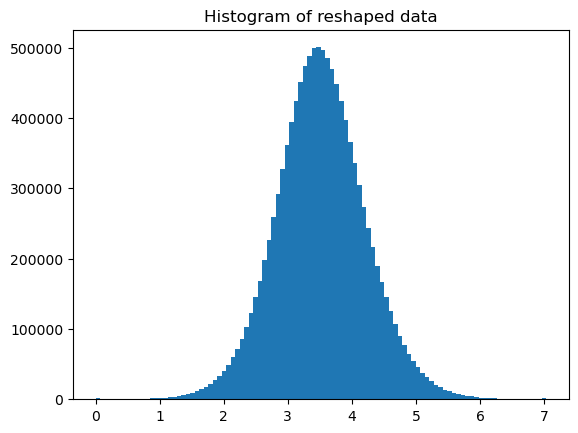

(1854, 6279)


In [8]:

temp = average_concept_epochs[:,:,:] - average_concept_epochs.mean(axis = (0,1)) # making sure each channel is centered
# set outlier points to max value 
dev = 5*np.std(temp)
temp[temp > dev] = dev
temp[temp < - dev] = - dev
temp = temp - np.min(temp)
plt.hist(temp.flatten(), bins = 100)
plt.title("Histogram of reshaped data")
plt.show()
X = temp.transpose(0,2,1).reshape(NOS_CONCEPTS, NOS_TIME_POINTS * NOS_CHANNELS_OPT) 
X = X - X.min()
print(X.shape) 


### Consensus NMF 

In [12]:
H, W = consensus_nmf(X, n_components=nmf_components, n_replicates=nos_seeds, p=0.3, tau=1, random_state=random_state)

/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it t

Categories which are best on component 0 are: [ 112 1148  838 1153  232 1355  647 1416  559  208 1814  496  463 1622
 1151  498  761 1164 1475 1674]
Categories which are best on component 1 are: [ 213 1335  872 1194 1468  326 1673 1207  401 1280 1745  108  582  632
  981  101 1297  227  603 1271]
Categories which are best on component 2 are: [1757  651  507 1328 1606  100  743 1157 1813 1250  953 1703  692  396
   88  732  482 1388 1006  639]
Categories which are best on component 3 are: [1839  984  224 1762 1557  450  608 1227 1511  960  315  811   98 1275
  276 1529  471  598 1620  863]
Categories which are best on component 4 are: [1843  259 1027 1474 1044 1005  469  177  292 1131  818  908  212   33
  870 1352 1665 1784  822 1361]
Categories which are best on component 5 are: [ 633 1456  192  899  462 1798  260  775 1542  264 1272  534 1245  985
 1039 1187 1701 1801 1050 1297]
Categories which are best on component 6 are: [ 446  348  628  403 1792  160  320  323 1803 1374  671  953

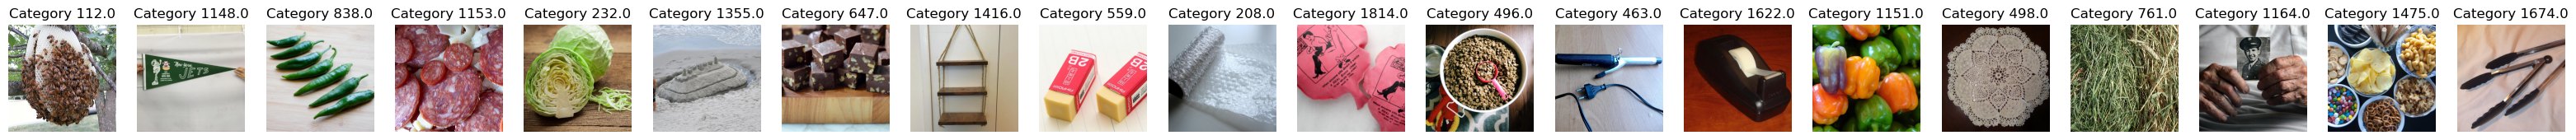

Component 1 is best loaded by the following image categories:


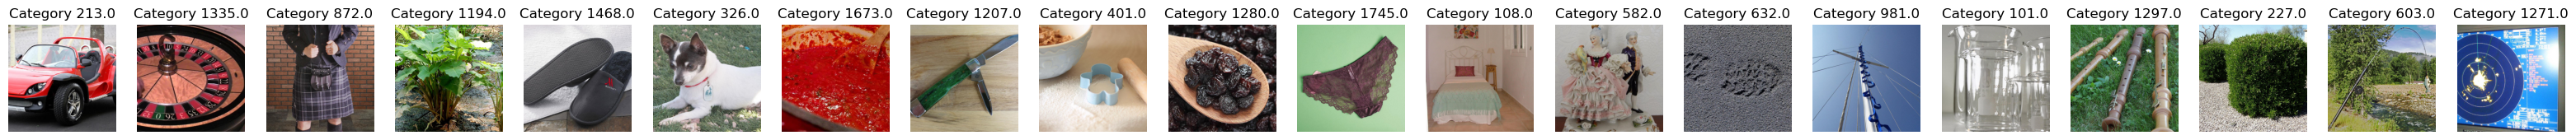

Component 2 is best loaded by the following image categories:


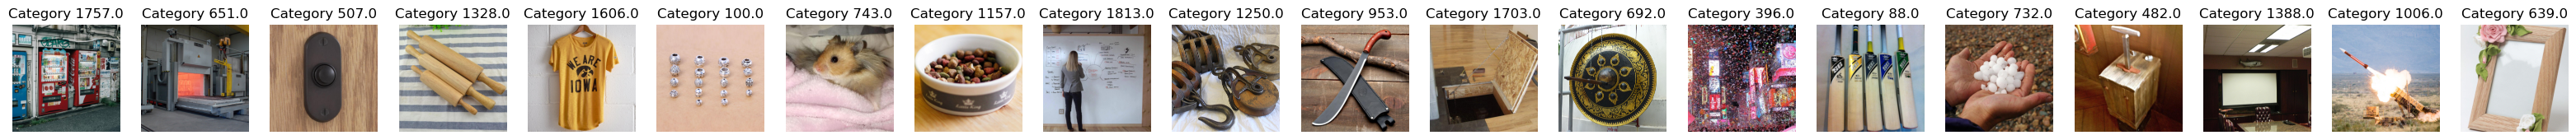

Component 3 is best loaded by the following image categories:


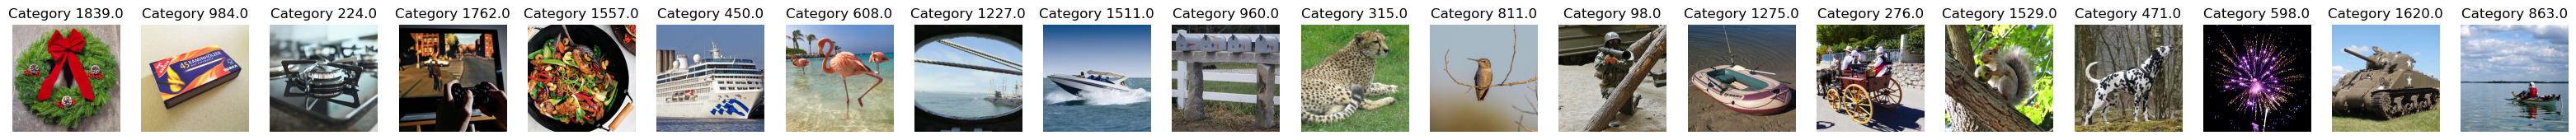

Component 4 is best loaded by the following image categories:


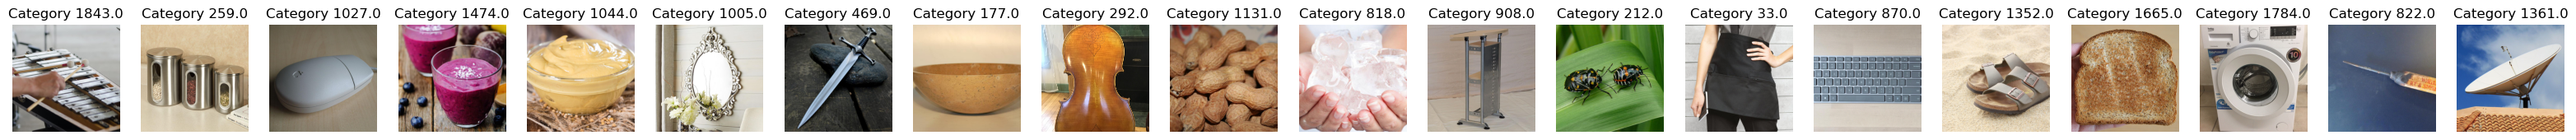

Component 5 is best loaded by the following image categories:


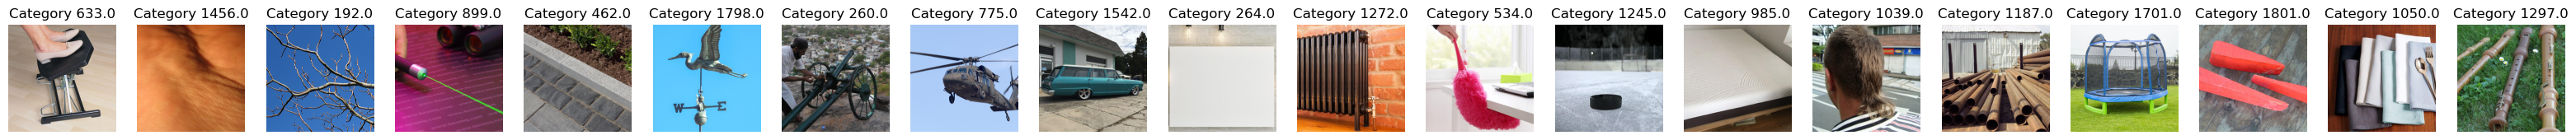

Component 6 is best loaded by the following image categories:


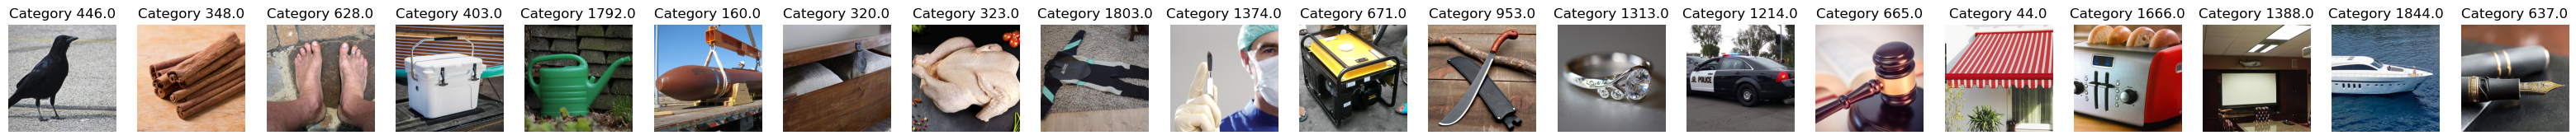

Component 7 is best loaded by the following image categories:


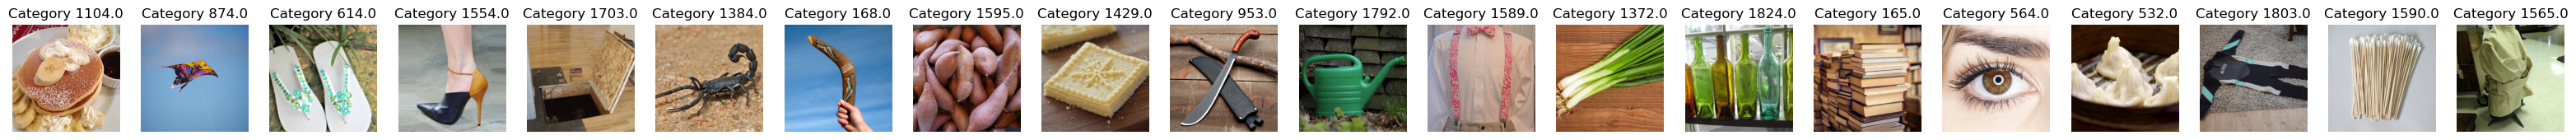

Component 8 is best loaded by the following image categories:


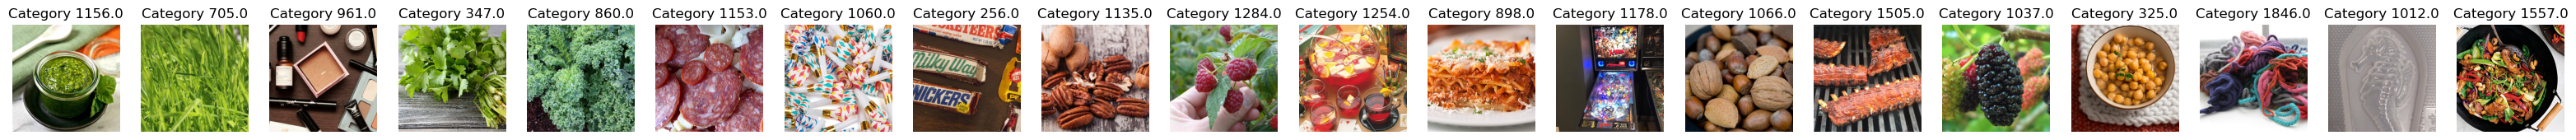

Component 9 is best loaded by the following image categories:


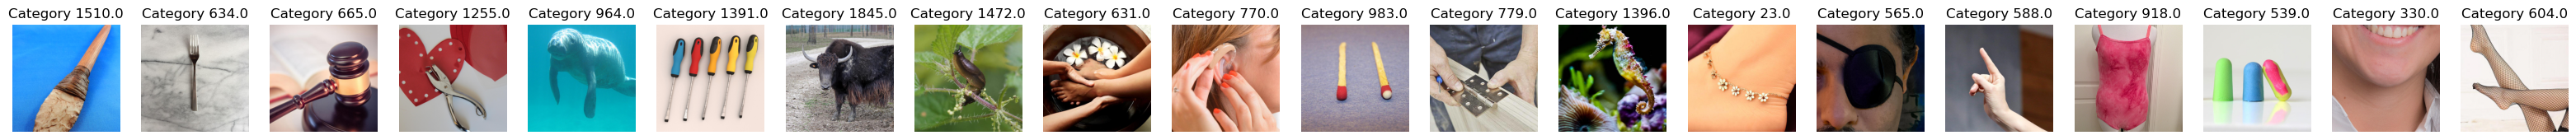

In [29]:

nmf_components_vs_category = np.zeros((nmf_components, images_to_show))
for i in range(nmf_components):
    sorted_indices = np.argsort(W[:,i])
    print(f'Categories which are best on component {i} are: {sorted_indices[-images_to_show:]}')
    nmf_components_vs_category[i,:] = sorted_indices[-images_to_show:]
# plot images for the top 5 categories for each component  
category_array_name = []
for component in range(nmf_components):
    if component > 20:
        break
    print(f"Component {component} is best loaded by the following image categories:")
    category_array = []
    fig, axs = plt.subplots(1, images_to_show, figsize=(40, 40))
    for i in range(images_to_show):
        category_nr = nmf_components_vs_category[component, i] 
        # Get the image paths for the given category_nr
        image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr+1) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
        image_path = image_paths.iloc[0]
        image_path = f'{image_dir}{image_path}'
        img = mpimg.imread(image_path)
        category_array.append(image_path.split('/')[-2])
        axs[i].imshow(img)
        axs[i].set_title(f"Category {category_nr}")
        axs[i].axis('off')
    plt.show()
    category_array_name.append(category_array)

In [30]:
category_array_name

[['beehive',
  'pennant',
  'jalapeno',
  'pepperoni',
  'cabbage',
  'sandcastle',
  'fudge',
  'shelf',
  'eraser',
  'bubble_wrap',
  'whoopee_cushion',
  'dogfood',
  'curling_iron',
  'tape',
  'pepper2',
  'doily',
  'hay',
  'photograph',
  'snack',
  'tongs'],
 ['buggy',
  'roulette_wheel',
  'kilt',
  'plant',
  'slipper',
  'chihuahua',
  'tomato_sauce',
  'pocketknife',
  'cookie_cutter',
  'raisin',
  'underwear',
  'bed',
  'figurine',
  'footprint',
  'mast',
  'beaker',
  'recorder',
  'bush',
  'fishing_pole',
  'radar'],
 ['vending_machine',
  'furnace',
  'doorbell',
  'rolling_pin',
  't-shirt',
  'bead',
  'hamster',
  'pet_food',
  'whiteboard',
  'pulley',
  'machete',
  'trapdoor',
  'gong',
  'confetti',
  'bat2',
  'hail',
  'detonator',
  'screen1',
  'missile',
  'frame'],
 ['wreath',
  'matchbox',
  'burner',
  'videogame',
  'stir_fry',
  'cruise_ship',
  'flamingo',
  'porthole',
  'speedboat',
  'mailbox',
  'cheetah',
  'hummingbird',
  'bazooka',
  'raf

### Time dynamics
To see how each component evolves with time

In [31]:
281*39

10959

In [32]:
print(H.shape)
comp_vs_time = H.reshape(nmf_components, NOS_CHANNELS_OPT, NOS_TIME_POINTS)


(10, 6279)


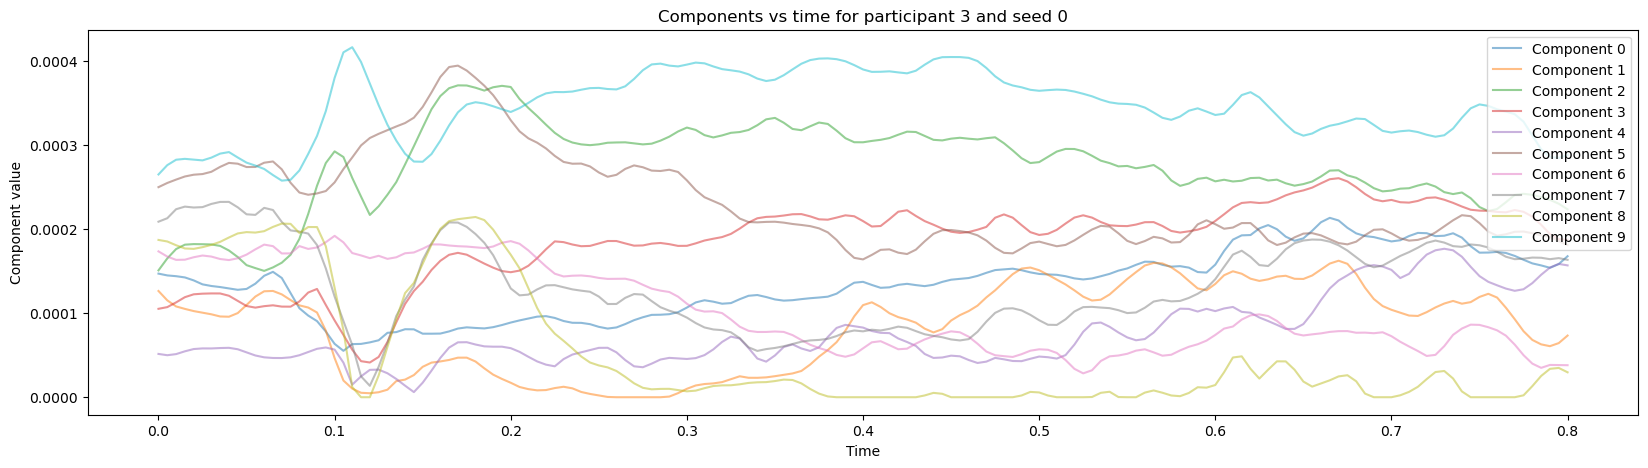

In [33]:
   
plt.figure(figsize=(20, 5)) 
# plt.plot(time_points, average_concept_epochs[0, :, 0], label = 'original data', linewidth=2)
# plt.plot(time_points, comp_vs_time[:, 0,:].sum(axis=0), label = 'NMF reconstruction', linewidth=2)
for i in range(nmf_components):
    plt.plot(time_points, comp_vs_time[i, 0,:], alpha=0.5, label=f'Component {i}')   
    # plt.plot(time_points, comp_vs_time[i, 0,:] - comp_vs_time[i,0,:20].mean(), alpha=0.2, label=f'Component {i}')
plt.title(f"Components vs time for participant {n_participants} and seed {random_state}")
plt.xlabel("Time")
plt.ylabel("Component value")
plt.legend()
plt.show()

In [34]:
# similarity matrix instead of reconstructing data matrix 

In [35]:
# correlation of dimensions with the categories

In [36]:
times = [-0.1,0.0, 0.170, 0.320, 0.5, 0.75, 1, 1.2]
nmf_components = 4 # 3 mins for 30 components

for time in times:
    index = epochs.times == time
    X = average_concept_epochs[:, index, :].squeeze()
    X += abs(X.min())
    model = NMF(n_components=nmf_components)
    W = model.fit_transform(X)
    H = model.components_
    X_pred = np.dot(W, H)   
    nmf_components_vs_category = np.zeros((nmf_components, 10))
    print(f'For time {time*1000} ms')
    for i in range(nmf_components):
        sorted_indices = np.argsort(W[:,i])
        # print(f'Categories which are best on component {i} are: {sorted_indices[-10:]}')
        nmf_components_vs_category[i,:] = sorted_indices[-10:]
    # plot images for the top 5 categories for each component   
    for component in range(nmf_components):
        if component > 20:
            break
        print(f"Component {component} is best loaded by the following image categories:")
        # fig, axs = plt.subplots(1, 10, figsize=(20, 20))
        for i in range(10):
            category_nr = nmf_components_vs_category[component, i] 
            # Get the image paths for the given category_nr
            image_paths = epochs.metadata[(epochs.metadata['category_nr'] == category_nr) & (epochs.metadata['trial_type'] == 'exp')]['image_path']
            print(image_paths)
            # print(image_paths.iloc[0])
            # image_path = image_paths.iloc[0]
            # image_path = f'../{image_path}'
            # img = mpimg.imread(image_path)
            # axs[i].imshow(img)
            # axs[i].set_title(f"Category {category_nr}")
            # axs[i].axis('off')
        # plt.show()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 161 but corresponding boolean dimension is 281